## Transfer Learning VGG 16 using Keras

In [20]:
!nvidia-smi

Sat Mar 11 10:12:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    48W / 400W |    909MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [22]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
ROOT_PATH = '/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project'

In [25]:
!pwd

/content/drive/My Drive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project


In [26]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project'

In [27]:
!ls

'Cat-Dog by VGG16.ipynb'   cat.jpg   dog.jpg   PetImages


In [28]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'PetImages/train'
valid_path = 'PetImages/validation'


In [29]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [30]:
# don't train existing weights
for layer in vgg16.layers:
  print(layer)

In [31]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [32]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [33]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
  # useful for getting number of output classes
folders = glob('PetImages/train/*')

In [35]:
folders

['PetImages/train/Dog', 'PetImages/train/Cat']

In [36]:
len(folders)

2

In [37]:
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [38]:
# view the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [40]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
!pwd

/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project


In [41]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('PetImages/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 337 images belonging to 2 classes.


In [42]:
test_set = test_datagen.flow_from_directory('PetImages/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 59 images belonging to 2 classes.


In [43]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
11/11 [==============================] - 56s 4s/step - loss: 2.5391 - accuracy: 0.5519 - val_loss: 0.4197 - val_accuracy: 0.8305
Epoch 2/10
11/11 [==============================] - 5s 414ms/step - loss: 0.6123 - accuracy: 0.7923 - val_loss: 0.4786 - val_accuracy: 0.7966
Epoch 3/10
11/11 [==============================] - 5s 412ms/step - loss: 0.2382 - accuracy: 0.8991 - val_loss: 0.5008 - val_accuracy: 0.7797
Epoch 4/10
11/11 [==============================] - 5s 413ms/step - loss: 0.1462 - accuracy: 0.9288 - val_loss: 0.4708 - val_accuracy: 0.8136
Epoch 5/10
11/11 [==============================] - 5s 412ms/step - loss: 0.1003 - accuracy: 0.9644 - val_loss: 0.4451 - val_accuracy: 0.7966
Epoch 6/10
11/11 [==============================] - 5s 408ms/step - loss: 0.0982 - accuracy: 0.9614 - val_loss: 0.4446 - val_accuracy: 0.7966
Epoch 7/10
11/11 [==============================] - 5s 411ms/step - loss: 0.0644 - accuracy: 0.9703 - val_loss: 0.4552 - val_accuracy: 0.8136
Epoch 8/

In [44]:
import matplotlib.pyplot as plt

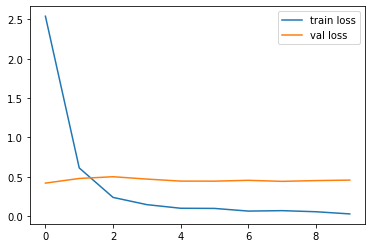

<Figure size 432x288 with 0 Axes>

In [45]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

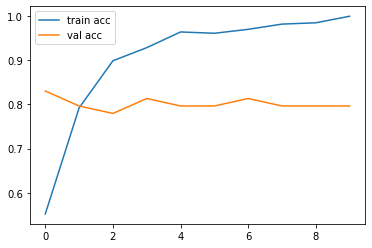

<Figure size 432x288 with 0 Axes>

In [46]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [47]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [48]:
y_pred = model.predict(test_set)

2/2 [==============================] - 0s 97ms/step


In [49]:
y_pred

array([[9.59317148e-01, 4.06828485e-02],
       [9.99929190e-01, 7.07546860e-05],
       [1.17676245e-04, 9.99882340e-01],
       [9.09115225e-02, 9.09088433e-01],
       [3.28017375e-03, 9.96719778e-01],
       [2.15989439e-05, 9.99978423e-01],
       [5.73697202e-02, 9.42630231e-01],
       [8.76679599e-01, 1.23320423e-01],
       [2.18677763e-02, 9.78132248e-01],
       [1.85245101e-03, 9.98147607e-01],
       [9.95703995e-01, 4.29596566e-03],
       [9.03553605e-01, 9.64463502e-02],
       [6.72873575e-03, 9.93271291e-01],
       [1.18675421e-03, 9.98813272e-01],
       [7.36744050e-03, 9.92632568e-01],
       [9.68932867e-01, 3.10671609e-02],
       [3.00082479e-06, 9.99997020e-01],
       [5.20900451e-02, 9.47909951e-01],
       [1.10951671e-03, 9.98890460e-01],
       [9.40091722e-03, 9.90599096e-01],
       [9.53309059e-01, 4.66909558e-02],
       [1.93624347e-01, 8.06375623e-01],
       [3.80158029e-03, 9.96198356e-01],
       [8.98371220e-01, 1.01628706e-01],
       [2.946685

In [50]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [51]:
y_pred

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [53]:
model=load_model('model_vgg16.h5')

In [54]:
img=image.load_img('cat.jpg',target_size=(224,224))

In [55]:
x=image.img_to_array(img)
x

array([[[ 36.,  41.,  37.],
        [ 38.,  42.,  41.],
        [ 38.,  42.,  43.],
        ...,
        [200., 200., 166.],
        [200., 198., 160.],
        [203., 201., 162.]],

       [[ 38.,  43.,  39.],
        [ 39.,  43.,  42.],
        [ 40.,  44.,  45.],
        ...,
        [208., 205., 172.],
        [205., 203., 165.],
        [204., 202., 163.]],

       [[ 42.,  47.,  43.],
        [ 40.,  44.,  43.],
        [ 40.,  44.,  45.],
        ...,
        [201., 198., 167.],
        [201., 196., 164.],
        [197., 193., 158.]],

       ...,

       [[ 30.,  28.,  29.],
        [ 24.,  22.,  23.],
        [ 21.,  19.,  20.],
        ...,
        [ 47.,  34.,  28.],
        [ 40.,  27.,  21.],
        [ 52.,  41.,  35.]],

       [[ 34.,  32.,  33.],
        [ 27.,  25.,  26.],
        [ 24.,  22.,  23.],
        ...,
        [ 45.,  32.,  24.],
        [ 44.,  31.,  23.],
        [ 65.,  55.,  46.]],

       [[ 30.,  28.,  29.],
        [ 26.,  24.,  25.],
        [ 24.,  

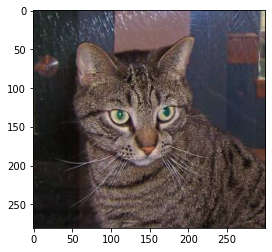

In [56]:
Z = plt.imread('cat.jpg')
plt.imshow(Z)

In [57]:
x.shape

(224, 224, 3)

In [58]:
x=x/255

In [59]:
from keras.applications.vgg16 import preprocess_input

In [60]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [61]:
model.predict(img_data)

1/1 [==============================] - 0s 345ms/step


array([[0.80416673, 0.19583331]], dtype=float32)

In [62]:
result = np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 26ms/step


In [63]:
result[0]

0

In [64]:
if result[0] == 1:
    prediction = 'dog'
    print(prediction)
else:
    prediction = 'cat'
    print(prediction)

cat
